In [1]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Path, PathPatch
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from statistics import mean
import numpy as np
import scipy.interpolate
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
import cartopy.feature as cfeature
from cartopy.feature import NaturalEarthFeature
import cartopy.mpl.geoaxes
import calendar

In [2]:
conn = sqlite3.connect('GeoPVWattData.db')
c = conn.cursor()

sql = """CREATE TABLE LatLonData(
         lat real,
         lon real,
         city text,
         state text,
         tilt real,
         azimuth real,
         azimuthname text,
         solrad_jan real,
         solrad_feb real,
         solrad_mar real,
         solrad_apr real,
         solrad_may real,
         solrad_jun real,
         solrad_jul real,
         solrad_aug real,
         solrad_sep real,
         solrad_oct real,
         solrad_nov real,
         solrad_dec real,
         solrad_average real,
       solrad_minus real,
         solrad_plus real,
         solrad_annual real,
         PRIMARY KEY (lat, lon, tilt, azimuth)
         )"""

In [3]:
def azimuthtitle(a):
    switcher = {
        0:'North',
        45:'NE', 
        90:'East', 
        135:'SE', 
        180:'South', 
        225:'SW', 
        270:'West', 
        315:'NW' 
    }
    return switcher.get(a,a)

In [4]:
def ptitle(s,t,a):
    d = {v.lower(): k for k,v in enumerate(calendar.month_abbr)}
    if s == "solrad_annual":
        pts = "Annual"
    else:
        pts = calendar.month_name[d[s[-3:]]]
    
    if t == 0:
        pt = "Horizontal"
        pa = ""
    elif t == 90:
        pt = "Vertical"
        pa = ", " + azimuthtitle(a) + ' Facing'
    else:
        pt = f"Tilt={t}\N{DEGREE SIGN}"
        pa = ", " + azimuthtitle(a) + ' Facing'
    
    return f"Average Solar Irradiance - {pts}, {pt}{pa}"

In [5]:
s = 'solrad_annual'
t = 0
a = 180

if t == 0:
    sql = f"SELECT lat, lon, {s} FROM LatLonData WHERE lat > 30 AND lat < 70 AND lon > -30 AND lon < 60 AND tilt = 0"
else:
    sql = f"SELECT lat, lon, {s} FROM LatLonData WHERE lat > 30 AND lat < 70 AND lon > -30 AND lon < 60 \
            AND tilt = {t} AND azimuth = {a}"
c.execute(sql)
# df=DataFrame(c.fetchall())
df = pd.read_sql(sql,conn)
print(df)


       lat    lon  solrad_annual
0    30.13  31.40          5.253
1    31.25  34.80          5.359
2    31.78  35.22          5.371
3    31.87  35.22          5.394
4    31.88  54.28          5.554
..     ...    ...            ...
210  61.42  23.58          2.517
211  63.18  14.50          2.428
212  64.13 -21.90          2.130
213  64.53  40.47          2.230
214  67.82  20.33          2.043

[215 rows x 3 columns]


2.039
5.855


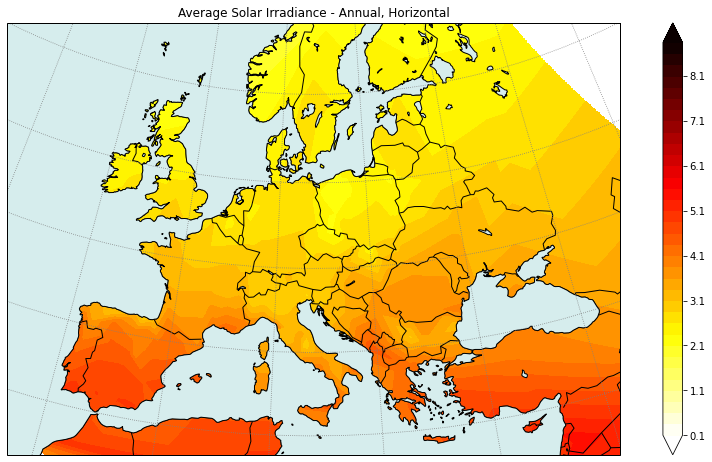

In [15]:
lons = df['lon'].tolist()
lats = df['lat'].tolist()
sol = df[s].tolist()

print(min(sol))
print(max(sol))

#setup grid of lat/lon values based on existing data
x, y = np.linspace(min(lons), max(lons), 500), np.linspace(min(lats), max(lats), 500)
x, y = np.meshgrid(x,y)
#interpolate solar radiation data over grid of lon/lat values
z = scipy.interpolate.griddata((lons, lats), sol, (x, y), method='linear')

#Create figure with desired earth projection and lat/lon framing desired
usleft = -12
usright = 39.75
usbottom = 31.5
ustop = 63
cenlon = usleft + (usright-usleft)/2
fig = plt.figure(figsize=[12,6])
ax = fig.add_axes([0, 0, 1, 1], projection=ccrs.LambertConformal(central_longitude=cenlon))
ax.set_extent([usleft, usright, usbottom, ustop], ccrs.Geodetic())


#Contour plot of solar radiation

# levels = [4, 4.25, 4.5, 4.75, 5, 5.25, 5.5, 5.75]
# levels = [2, 2.25, 2.5, 2.75, 3, 3.25, 3.5, 3.75]
# clrs = ([1,0.9294,0.6314],[0.9922,0.8549,0.4627],[0.9922,0.6980,0.2980],
#         [0.9961,0.5529,0.2392],[0.9882,0.3059,0.1686],[0.8941,0.0980,0.1098],
#         [0.7412,0,0.1490])
# cplot=plt.contourf(x, y,z, levels,colors=clrs,transform=ccrs.PlateCarree(),extend='both')
# cplot.cmap.set_under([1,1,0.8078])
# cplot.cmap.set_over([0.5059,0,0.1490])

# # Add a color bar
# # plt.colorbar(ax=ax, shrink=.98)
# cbar = fig.colorbar(cplot,ax=ax, fraction=0.025, pad = 0.02, aspect=10, anchor=(0,0), extend='both', 
#              extendfrac='auto',extendrect=True)
# cbar.set_ticklabels = levels
# cbar.ax.set_ylabel('kWh/m2/Day')

levels = [.25,.5, 1, 1.5, 2, 2.5, 3, 3.5, 4,4.5,5,5.5,6,6.5,7,7.5,8]
levels = np.arange(0.1,9,0.25)
# levels = np.arange(0.1,4.5,0.25)
cplot=plt.contourf(x, y,z, levels,transform=ccrs.PlateCarree(),extend='both',
                   cmap=plt.get_cmap('hot_r'))
cbar = fig.colorbar(cplot,ax=ax)



# ax.set_title('Horizontal Solar Irradiance')
ax.set_title('West Vertical Solar Irradiance')
ax.set_title(ptitle(s,t,a))

# #Color Canada and Mexico gray
# shpfilename = shpreader.natural_earth(resolution='110m',
#                                       category='cultural',
#                                       name='admin_0_countries')
# reader = shpreader.Reader(shpfilename)
# countries = reader.records()
# for country in countries:
#     att = country.attributes['ADM0_A3']
#     if att == 'CAN' or att == 'MEX':
#         ax.add_geometries(country.geometry, ccrs.PlateCarree(),
#                           facecolor=(0.9, 0.9, 0.9),edgecolor=(0,0,0),
#                           label=country.attributes['ADM0_A3'])

# #Add in state lines
# states = NaturalEarthFeature(category="cultural", scale="10m",
#                              facecolor="none",
#                              name="admin_1_states_provinces_shp")
# ax.add_feature(states, linewidth=.5, edgecolor="black")


ax.add_feature(cfeature.BORDERS)
        
#add coastlines, lat/lon lines, color ocean white
ax.coastlines('50m', linewidth=0.8)
ax.add_feature(NaturalEarthFeature('physical', 'ocean', '50m', edgecolor='k', facecolor=(0.84 , 0.93, 0.93)))
ax.add_feature(NaturalEarthFeature('physical', 'lakes', '50m', edgecolor='k', facecolor=(0.84 , 0.93, 0.93)))

ax.gridlines(color=(0.5,0.5,0.5), linestyle="dotted")


plt.savefig("test.svg")
plt.show()



1.29
4.256


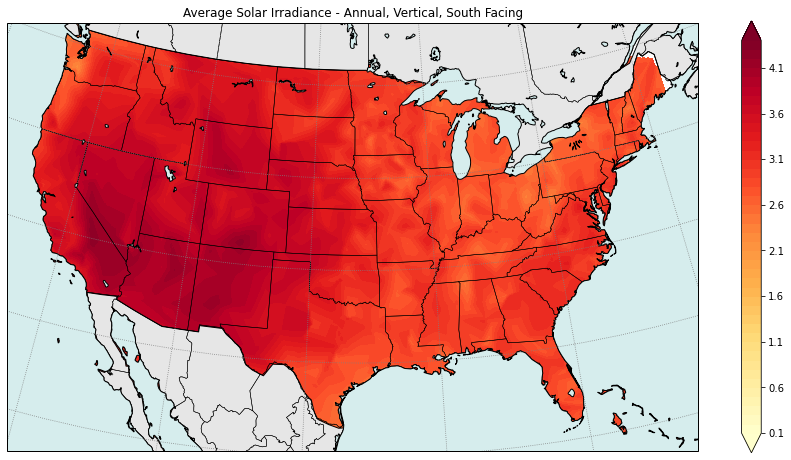

In [481]:
lons = df['lon'].tolist()
lats = df['lat'].tolist()
sol = df[s].tolist()

print(min(sol))
print(max(sol))

#setup grid of lat/lon values based on existing data
x, y = np.linspace(min(lons), max(lons), 500), np.linspace(min(lats), max(lats), 500)
x, y = np.meshgrid(x,y)
#interpolate solar radiation data over grid of lon/lat values
z = scipy.interpolate.griddata((lons, lats), sol, (x, y), method='linear')

#Create figure with desired earth projection and lat/lon framing desired
fig = plt.figure(figsize=[12,6])
ax = fig.add_axes([0, 0, 1, 1], projection=ccrs.LambertConformal())
usleft = -120
usright = -73
usbottom = 22
ustop = 50
ax.set_extent([usleft, usright, usbottom, ustop], ccrs.Geodetic())


#Contour plot of solar radiation

# levels = [4, 4.25, 4.5, 4.75, 5, 5.25, 5.5, 5.75]
# levels = [2, 2.25, 2.5, 2.75, 3, 3.25, 3.5, 3.75]
# clrs = ([1,0.9294,0.6314],[0.9922,0.8549,0.4627],[0.9922,0.6980,0.2980],
#         [0.9961,0.5529,0.2392],[0.9882,0.3059,0.1686],[0.8941,0.0980,0.1098],
#         [0.7412,0,0.1490])
# cplot=plt.contourf(x, y,z, levels,colors=clrs,transform=ccrs.PlateCarree(),extend='both')
# cplot.cmap.set_under([1,1,0.8078])
# cplot.cmap.set_over([0.5059,0,0.1490])

# # Add a color bar
# # plt.colorbar(ax=ax, shrink=.98)
# cbar = fig.colorbar(cplot,ax=ax, fraction=0.025, pad = 0.02, aspect=10, anchor=(0,0), extend='both', 
#              extendfrac='auto',extendrect=True)
# cbar.set_ticklabels = levels
# cbar.ax.set_ylabel('kWh/m2/Day')

levels = [.25,.5, 1, 1.5, 2, 2.5, 3, 3.5, 4,4.5,5,5.5,6,6.5,7,7.5,8]
levels = np.arange(0.1,9,0.1)
levels = np.arange(0.1,4.5,0.1)
cplot=plt.contourf(x, y,z, levels,transform=ccrs.PlateCarree(),extend='both',
                   cmap=plt.get_cmap('YlOrRd'))
cbar = fig.colorbar(cplot,ax=ax)



# ax.set_title('Horizontal Solar Irradiance')
ax.set_title('West Vertical Solar Irradiance')
ax.set_title(ptitle(s,t,a))

#Color Canada and Mexico gray
shpfilename = shpreader.natural_earth(resolution='110m',
                                      category='cultural',
                                      name='admin_0_countries')
reader = shpreader.Reader(shpfilename)
countries = reader.records()
for country in countries:
    att = country.attributes['ADM0_A3']
    if att == 'CAN' or att == 'MEX':
        ax.add_geometries(country.geometry, ccrs.PlateCarree(),
                          facecolor=(0.9, 0.9, 0.9),edgecolor=(0,0,0),
                          label=country.attributes['ADM0_A3'])

#Add in state lines
states = NaturalEarthFeature(category="cultural", scale="10m",
                             facecolor="none",
                             name="admin_1_states_provinces_shp")
ax.add_feature(states, linewidth=.5, edgecolor="black")


        
#add coastlines, lat/lon lines, color ocean white
ax.coastlines('50m', linewidth=0.8)
ax.add_feature(NaturalEarthFeature('physical', 'ocean', '50m', edgecolor='k', facecolor=(0.84 , 0.93, 0.93)))
ax.add_feature(NaturalEarthFeature('physical', 'lakes', '50m', edgecolor='k', facecolor=(0.84 , 0.93, 0.93)))

ax.gridlines(color=(0.5,0.5,0.5), linestyle="dotted")


plt.savefig("test.svg")
plt.show()


1.29
4.256


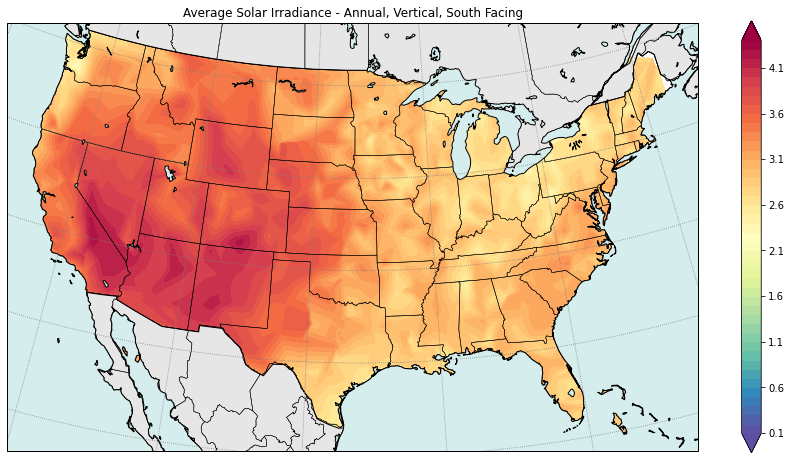

In [482]:
lons = df['lon'].tolist()
lats = df['lat'].tolist()
sol = df[s].tolist()

print(min(sol))
print(max(sol))

#setup grid of lat/lon values based on existing data
x, y = np.linspace(min(lons), max(lons), 500), np.linspace(min(lats), max(lats), 500)
x, y = np.meshgrid(x,y)
#interpolate solar radiation data over grid of lon/lat values
z = scipy.interpolate.griddata((lons, lats), sol, (x, y), method='linear')

#Create figure with desired earth projection and lat/lon framing desired
fig = plt.figure(figsize=[12,6])
ax = fig.add_axes([0, 0, 1, 1], projection=ccrs.LambertConformal())
usleft = -120
usright = -73
usbottom = 22
ustop = 50
ax.set_extent([usleft, usright, usbottom, ustop], ccrs.Geodetic())


#Contour plot of solar radiation

# levels = [4, 4.25, 4.5, 4.75, 5, 5.25, 5.5, 5.75]
# levels = [2, 2.25, 2.5, 2.75, 3, 3.25, 3.5, 3.75]
# clrs = ([1,0.9294,0.6314],[0.9922,0.8549,0.4627],[0.9922,0.6980,0.2980],
#         [0.9961,0.5529,0.2392],[0.9882,0.3059,0.1686],[0.8941,0.0980,0.1098],
#         [0.7412,0,0.1490])
# cplot=plt.contourf(x, y,z, levels,colors=clrs,transform=ccrs.PlateCarree(),extend='both')
# cplot.cmap.set_under([1,1,0.8078])
# cplot.cmap.set_over([0.5059,0,0.1490])

# # Add a color bar
# # plt.colorbar(ax=ax, shrink=.98)
# cbar = fig.colorbar(cplot,ax=ax, fraction=0.025, pad = 0.02, aspect=10, anchor=(0,0), extend='both', 
#              extendfrac='auto',extendrect=True)
# cbar.set_ticklabels = levels
# cbar.ax.set_ylabel('kWh/m2/Day')

levels = [.25,.5, 1, 1.5, 2, 2.5, 3, 3.5, 4,4.5,5,5.5,6,6.5,7,7.5,8]
levels = np.arange(0.1,8.5,0.1)
levels = np.arange(0.1,4.5,0.1)
cplot=plt.contourf(x, y,z, levels,transform=ccrs.PlateCarree(),extend='both',
                   cmap=plt.get_cmap('Spectral_r'))
cbar = fig.colorbar(cplot,ax=ax)



# ax.set_title('Horizontal Solar Irradiance')
ax.set_title('West Vertical Solar Irradiance')
ax.set_title(ptitle(s,t,a))

#Color Canada and Mexico gray
shpfilename = shpreader.natural_earth(resolution='110m',
                                      category='cultural',
                                      name='admin_0_countries')
reader = shpreader.Reader(shpfilename)
countries = reader.records()
for country in countries:
    att = country.attributes['ADM0_A3']
    if att == 'CAN' or att == 'MEX':
        ax.add_geometries(country.geometry, ccrs.PlateCarree(),
                          facecolor=(0.9, 0.9, 0.9),edgecolor=(0,0,0),
                          label=country.attributes['ADM0_A3'])

#Add in state lines
states = NaturalEarthFeature(category="cultural", scale="10m",
                             facecolor="none",
                             name="admin_1_states_provinces_shp")
ax.add_feature(states, linewidth=.5, edgecolor="black")


        
#add coastlines, lat/lon lines, color ocean white
ax.coastlines('50m', linewidth=0.8)
ax.add_feature(NaturalEarthFeature('physical', 'ocean', '50m', edgecolor='k', facecolor=(0.84 , 0.93, 0.93)))
ax.add_feature(NaturalEarthFeature('physical', 'lakes', '50m', edgecolor='k', facecolor=(0.84 , 0.93, 0.93)))

ax.gridlines(color=(0.5,0.5,0.5), linestyle="dotted")


plt.savefig("test.svg")
plt.show()


1.29
4.256


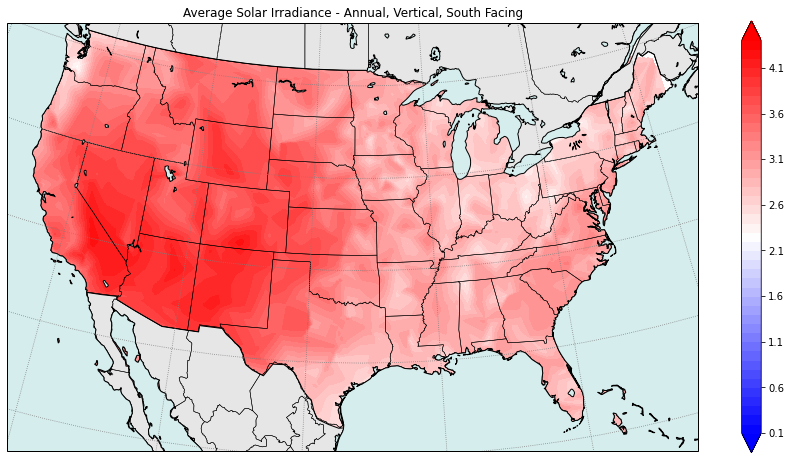

In [483]:
lons = df['lon'].tolist()
lats = df['lat'].tolist()
sol = df[s].tolist()

print(min(sol))
print(max(sol))

#setup grid of lat/lon values based on existing data
x, y = np.linspace(min(lons), max(lons), 500), np.linspace(min(lats), max(lats), 500)
x, y = np.meshgrid(x,y)
#interpolate solar radiation data over grid of lon/lat values
z = scipy.interpolate.griddata((lons, lats), sol, (x, y), method='linear')

#Create figure with desired earth projection and lat/lon framing desired
fig = plt.figure(figsize=[12,6])
ax = fig.add_axes([0, 0, 1, 1], projection=ccrs.LambertConformal())
usleft = -120
usright = -73
usbottom = 22
ustop = 50
ax.set_extent([usleft, usright, usbottom, ustop], ccrs.Geodetic())


#Contour plot of solar radiation

# levels = [4, 4.25, 4.5, 4.75, 5, 5.25, 5.5, 5.75]
# levels = [2, 2.25, 2.5, 2.75, 3, 3.25, 3.5, 3.75]
# clrs = ([1,0.9294,0.6314],[0.9922,0.8549,0.4627],[0.9922,0.6980,0.2980],
#         [0.9961,0.5529,0.2392],[0.9882,0.3059,0.1686],[0.8941,0.0980,0.1098],
#         [0.7412,0,0.1490])
# cplot=plt.contourf(x, y,z, levels,colors=clrs,transform=ccrs.PlateCarree(),extend='both')
# cplot.cmap.set_under([1,1,0.8078])
# cplot.cmap.set_over([0.5059,0,0.1490])

# # Add a color bar
# # plt.colorbar(ax=ax, shrink=.98)
# cbar = fig.colorbar(cplot,ax=ax, fraction=0.025, pad = 0.02, aspect=10, anchor=(0,0), extend='both', 
#              extendfrac='auto',extendrect=True)
# cbar.set_ticklabels = levels
# cbar.ax.set_ylabel('kWh/m2/Day')

levels = [.25,.5, 1, 1.5, 2, 2.5, 3, 3.5, 4,4.5,5,5.5,6,6.5,7,7.5,8]
levels = np.arange(0.1,8.5,0.1)
levels = np.arange(0.1,4.5,0.1)
cplot=plt.contourf(x, y,z, levels,transform=ccrs.PlateCarree(),extend='both',
                   cmap=plt.get_cmap('bwr'))
cbar = fig.colorbar(cplot,ax=ax)



# ax.set_title('Horizontal Solar Irradiance')
ax.set_title('West Vertical Solar Irradiance')
ax.set_title(ptitle(s,t,a))

#Color Canada and Mexico gray
shpfilename = shpreader.natural_earth(resolution='110m',
                                      category='cultural',
                                      name='admin_0_countries')
reader = shpreader.Reader(shpfilename)
countries = reader.records()
for country in countries:
    att = country.attributes['ADM0_A3']
    if att == 'CAN' or att == 'MEX':
        ax.add_geometries(country.geometry, ccrs.PlateCarree(),
                          facecolor=(0.9, 0.9, 0.9),edgecolor=(0,0,0),
                          label=country.attributes['ADM0_A3'])

#Add in state lines
states = NaturalEarthFeature(category="cultural", scale="10m",
                             facecolor="none",
                             name="admin_1_states_provinces_shp")
ax.add_feature(states, linewidth=.5, edgecolor="black")


        
#add coastlines, lat/lon lines, color ocean white
ax.coastlines('50m', linewidth=0.8)
ax.add_feature(NaturalEarthFeature('physical', 'ocean', '50m', edgecolor='k', facecolor=(0.84 , 0.93, 0.93)))
ax.add_feature(NaturalEarthFeature('physical', 'lakes', '50m', edgecolor='k', facecolor=(0.84 , 0.93, 0.93)))

ax.gridlines(color=(0.5,0.5,0.5), linestyle="dotted")


plt.savefig("test.svg")
plt.show()

1.29
4.256


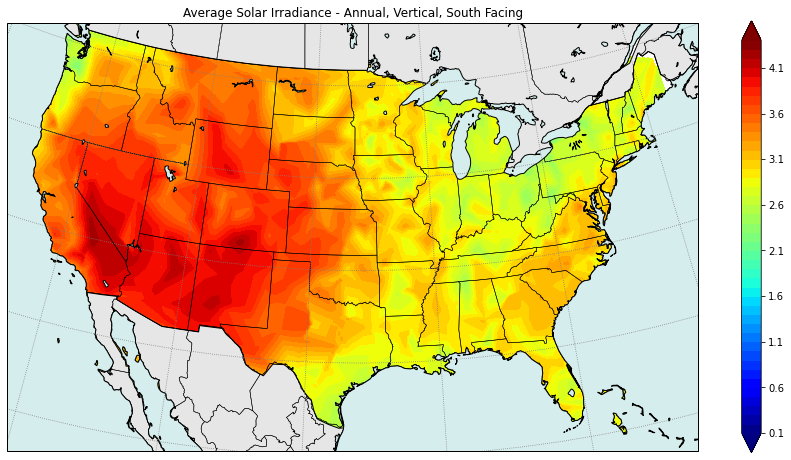

In [484]:
lons = df['lon'].tolist()
lats = df['lat'].tolist()
sol = df[s].tolist()

print(min(sol))
print(max(sol))

#setup grid of lat/lon values based on existing data
x, y = np.linspace(min(lons), max(lons), 500), np.linspace(min(lats), max(lats), 500)
x, y = np.meshgrid(x,y)
#interpolate solar radiation data over grid of lon/lat values
z = scipy.interpolate.griddata((lons, lats), sol, (x, y), method='linear')

#Create figure with desired earth projection and lat/lon framing desired
fig = plt.figure(figsize=[12,6])
ax = fig.add_axes([0, 0, 1, 1], projection=ccrs.LambertConformal())
usleft = -120
usright = -73
usbottom = 22
ustop = 50
ax.set_extent([usleft, usright, usbottom, ustop], ccrs.Geodetic())


#Contour plot of solar radiation

# levels = [4, 4.25, 4.5, 4.75, 5, 5.25, 5.5, 5.75]
# levels = [2, 2.25, 2.5, 2.75, 3, 3.25, 3.5, 3.75]
# clrs = ([1,0.9294,0.6314],[0.9922,0.8549,0.4627],[0.9922,0.6980,0.2980],
#         [0.9961,0.5529,0.2392],[0.9882,0.3059,0.1686],[0.8941,0.0980,0.1098],
#         [0.7412,0,0.1490])
# cplot=plt.contourf(x, y,z, levels,colors=clrs,transform=ccrs.PlateCarree(),extend='both')
# cplot.cmap.set_under([1,1,0.8078])
# cplot.cmap.set_over([0.5059,0,0.1490])

# # Add a color bar
# # plt.colorbar(ax=ax, shrink=.98)
# cbar = fig.colorbar(cplot,ax=ax, fraction=0.025, pad = 0.02, aspect=10, anchor=(0,0), extend='both', 
#              extendfrac='auto',extendrect=True)
# cbar.set_ticklabels = levels
# cbar.ax.set_ylabel('kWh/m2/Day')

levels = [.25,.5, 1, 1.5, 2, 2.5, 3, 3.5, 4,4.5,5,5.5,6,6.5,7,7.5,8]
levels = np.arange(0.1,8.5,0.1)
levels = np.arange(0.1,4.5,0.1)
cplot=plt.contourf(x, y,z, levels,transform=ccrs.PlateCarree(),extend='both',
                   cmap=plt.get_cmap('jet'))
cbar = fig.colorbar(cplot,ax=ax)



# ax.set_title('Horizontal Solar Irradiance')
ax.set_title('West Vertical Solar Irradiance')
ax.set_title(ptitle(s,t,a))

#Color Canada and Mexico gray
shpfilename = shpreader.natural_earth(resolution='110m',
                                      category='cultural',
                                      name='admin_0_countries')
reader = shpreader.Reader(shpfilename)
countries = reader.records()
for country in countries:
    att = country.attributes['ADM0_A3']
    if att == 'CAN' or att == 'MEX':
        ax.add_geometries(country.geometry, ccrs.PlateCarree(),
                          facecolor=(0.9, 0.9, 0.9),edgecolor=(0,0,0),
                          label=country.attributes['ADM0_A3'])

#Add in state lines
states = NaturalEarthFeature(category="cultural", scale="10m",
                             facecolor="none",
                             name="admin_1_states_provinces_shp")
ax.add_feature(states, linewidth=.5, edgecolor="black")


        
#add coastlines, lat/lon lines, color ocean white
ax.coastlines('50m', linewidth=0.8)
ax.add_feature(NaturalEarthFeature('physical', 'ocean', '50m', edgecolor='k', facecolor=(0.84 , 0.93, 0.93)))
ax.add_feature(NaturalEarthFeature('physical', 'lakes', '50m', edgecolor='k', facecolor=(0.84 , 0.93, 0.93)))

ax.gridlines(color=(0.5,0.5,0.5), linestyle="dotted")


plt.savefig("test.svg")
plt.show()

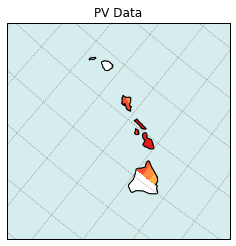

In [224]:
lons = df['lon'].tolist()
lats = df['lat'].tolist()
sol = df['solrad_annual'].tolist()

ak_left=-175
ak_right=-140
ak_low=50
ak_hi=72

ha_left=-161
ha_right=-154
ha_low=18
ha_hi=23
#setup grid of lat/lon values based on existing data
x, y = np.linspace(ha_left, ha_right, 300), np.linspace(ha_low, ha_hi, 300)
x, y = np.meshgrid(x,y)
#interpolate solar radiation data over grid of lon/lat values
z = scipy.interpolate.griddata((lons, lats), sol, (x, y), method='linear')

#Create figure with desired earth projection and lat/lon framing desired
fig = plt.figure(figsize=[6,3])
ax = fig.add_axes([0, 0, 1, 1], projection=ccrs.LambertConformal())

ax.set_extent([ha_left, ha_right, ha_low, ha_hi], ccrs.Geodetic())


#Contour plot of solar radiation
levels = [0, 4, 4.25, 4.5, 4.75, 5, 5.25, 5.5, 5.75, 10]
clrs = ([1,1,0.8078],[1,0.9294,0.6314],[0.9922,0.8549,0.4627],[0.9922,0.6980,0.2980],
        [0.9961,0.5529,0.2392],[0.9882,0.3059,0.1686],[0.8941,0.0980,0.1098],
        [0.7412,0,0.1490],[0.5059,0,0.1490])
levels = [4, 4.25, 4.5, 4.75, 5, 5.25, 5.5, 5.75]
clrs = ([1,0.9294,0.6314],[0.9922,0.8549,0.4627],[0.9922,0.6980,0.2980],
        [0.9961,0.5529,0.2392],[0.9882,0.3059,0.1686],[0.8941,0.0980,0.1098],
        [0.7412,0,0.1490])
cplot=plt.contourf(x, y,z, levels,colors=clrs,transform=ccrs.PlateCarree(),extend='both')
cplot.cmap.set_under([1,1,0.8078])
cplot.cmap.set_over([0.5059,0,0.1490])


ax.set_title('PV Data')

#Color Canada and Mexico gray
shpfilename = shpreader.natural_earth(resolution='110m',
                                      category='cultural',
                                      name='admin_0_countries')
reader = shpreader.Reader(shpfilename)
countries = reader.records()
for country in countries:
    att = country.attributes['ADM0_A3']
    if att == 'CAN' or att == 'MEX':
        ax.add_geometries(country.geometry, ccrs.PlateCarree(),
                          facecolor=(0.9, 0.9, 0.9),edgecolor=(0,0,0),
                          label=country.attributes['ADM0_A3'])

#Add in state lines
states = NaturalEarthFeature(category="cultural", scale="10m",
                             facecolor="none",
                             name="admin_1_states_provinces_shp")
ax.add_feature(states, linewidth=.5, edgecolor="black")


        
#add coastlines, lat/lon lines, color ocean white
ax.coastlines('50m', linewidth=0.8)
ax.add_feature(NaturalEarthFeature('physical', 'ocean', '50m', edgecolor='k', facecolor=(0.84 , 0.93, 0.93)))
ax.add_feature(NaturalEarthFeature('physical', 'lakes', '50m', edgecolor='k', facecolor=(0.84 , 0.93, 0.93)))

ax.gridlines(color=(0.5,0.5,0.5), linestyle="dotted")






In [16]:
conn.close()

#inset axis
# axins = ax.inset_axes([0,0,0.2,0.2])
# axins.set_xlim(usleft,usright)
# axins.set_ylim(usbottom,ustop)

# axins = fig.add_axes([0, 0, 1, 1], projection=ccrs.LambertConformal())

axins = inset_axes(ax, width="20%", height="20%", loc="lower left", 
                   axes_class=cartopy.mpl.geoaxes.GeoAxes, 
                   axes_kwargs=dict(map_projection=cartopy.crs.PlateCarree()))
axins.add_feature(cartopy.feature.COASTLINE)
axins.set_xlim(-175,-140)
axins.set_ylim(50,72)

axins.contourf(x, y,z, levels,colors=clrs,transform=ccrs.PlateCarree(),extend='both')


axins2 = inset_axes(ax, width="20%", height="20%", loc="lower left", 
                   axes_class=cartopy.mpl.geoaxes.GeoAxes, 
                   axes_kwargs=dict(map_projection=cartopy.crs.PlateCarree()))
axins2.add_feature(cartopy.feature.COASTLINE)
axins2.set_xlim(-161,-154)
axins2.set_ylim(18,23)

axins2.contourf(x, y,z, levels,colors=clrs,transform=ccrs.PlateCarree(),extend='both')